# Accidents prediction 🚗

Описание тут

**Содержание**<a id='toc0_'></a>    
1. [Подготовка   ](#toc1_)    
1.1. [Библиотеки   ](#toc1_1_)    
1.2. [Конфигурация   ](#toc1_2_)    
1.3. [Сервисные функции](#toc1_3_)    
2. [Первичный осмотр таблиц   ](#toc2_)    
2.1. [Таблица `collisions`   ](#toc2_1_)    
2.2. [Таблица `parties` ](#toc2_2_)    
2.3. [Таблица `vehicles` ](#toc2_3_)    
2.4. [Выводы ](#toc2_4_)    
3. [Статистический анализ факторов ДТП  ](#toc3_)    
3.1. [Самый частый месяц ДТП  ](#toc3_1_)    
3.2. [Задачи для коллег](#toc3_2_)    
3.3. [Реализации задачи 1](#toc3_3_)    
3.4. [Реализация задачи 5](#toc3_4_)    
4. [Данные](#toc4_)    
4.1. [Загрузка данных](#toc4_1_)    
4.2. [Отбор признаков](#toc4_2_)    
4.3. [Проверка типов данных](#toc4_3_)    
4.4. [Оптимизация памяти](#toc4_4_)    
4.5. [Проверка полных дубликатов](#toc4_5_)    
4.6. [Проверка пропусков](#toc4_6_)    
4.7. [Корреляция](#toc4_7_)    
4.8. [Вывод](#toc4_8_)    
5. [Модели](#toc5_)    
6. [Проверка на тесте](#toc6_)    
7. [Вывод](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>Подготовка    [&#8593;](#toc0_)

### 1.1. <a id='toc1_1_'></a>Библиотеки    [&#8593;](#toc0_)

In [2]:
from IPython.display import clear_output

In [ ]:
%pip install -q catboost==1.2.7
%pip install -q hyperopt==0.2.7
%pip install -q lightgbm==4.5.0
%pip install -q matplotlib==3.9.2
%pip install -q numpy==1.26.4
%pip install -q pandas==2.2.3
%pip install -q psycopg2==2.9.9
%pip install -q phik==0.12.4
%pip install -q prettytable==3.12.0
%pip install -q scikit-learn==1.5.2
%pip install -q seaborn==0.13.2
%pip install -q statsmodels==0.14.4
%pip install -q sqlalchemy==2.0.37
%pip install -q termcolor==2.5.0

clear_output()

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from sqlalchemy import create_engine
from termcolor import colored
from prettytable import PrettyTable
from phik import phik_matrix  # this import IS accessed
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.mosaicplot import mosaic

### 1.2. <a id='toc1_2_'></a>Конфигурация    [&#8593;](#toc0_)

In [5]:
RANDOM_STATE = 27
TEST_SIZE = 0.2

In [6]:
user = 'praktikum_student'
pwd = 'Sdf4$2;d-d30pp'
host = 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net'
port = 6432
db = 'data-science-vehicle-db'

In [7]:
connection_string = f'postgresql://{user}:{pwd}@{host}:{port}/{db}'
engine = create_engine(connection_string)

In [8]:
import warnings
warnings.filterwarnings('ignore')

### 1.3. <a id='toc1_3_'></a>Сервисные функции [&#8593;](#toc0_)

In [9]:
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    """Function optimizes memory usage in dataframe

    Args:
        df (pd.DataFrame): DataFrame to optimize.
        print_size (bool, optional): display of optimization results. Defaults to True.

    Returns:
        pd.DataFrame: optimized DataFrame
    """

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)

    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size:
        print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                            .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [10]:
def check_duplicates(df: pd.DataFrame) -> None:
    duplicates_count = df.duplicated().sum()

    if duplicates_count == 0:
        print(colored('Полных дубликатов не обнаружено.', 'green'))
        return

    duplicates_part = duplicates_count / len(df)
    print(colored(f'Обнаружено {duplicates_count} дубликатов ({duplicates_part:.2%})', 'red'))

In [11]:
def check_nans(df: pd.DataFrame) -> None:
    if df.isna().sum().sum() == 0:
        print(colored('Полных дубликатов не обнаружено.', 'green'))
        return

    table = PrettyTable()
    table.field_names = ['Feature', 'Missing values count']

    missing_info = df.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'green' if count == 0 else 'red'
        s = f'{count} ({count / len(df):.2%})'
        table.add_row([col, colored(s, color)])

    print(table)

In [12]:
def get_info_about_nan_in_series(series: pd.Series) -> None:
    nan_cnt = series.isna().sum()
    text = colored('No missing values', 'green') if nan_cnt == 0 \
        else colored(f'{nan_cnt} ({nan_cnt / len(series):.2%})', 'red')
    print(text)

In [13]:
def get_value_counts(series: pd.Series) -> None:
    data = pd.DataFrame()
    data['count'] = series.value_counts()
    data['part'] =series.value_counts(normalize=True)
    display(data)

In [14]:
def draw_plots_about_column(df: pd.DataFrame,
                            column: str,
                            column_description: str = None,
                            bins: int = 20
                            ) -> None:
    if column_description is None:
        column_description = column

    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

    sns.violinplot(df, x=column, ax=ax1, orient='h')
    ax1.set_xlabel(column_description)
    ax1.grid()

    sns.boxplot(df, x=column, ax=ax2)
    ax2.set_xlabel(column_description)
    ax2.grid()

    sns.histplot(df, x=column, bins=bins, ax=ax3)
    ax3.set_xlabel(column_description)
    ax3.grid()
    ax3.set_ylabel('Количество')

    ax4.set_visible(False)

    plt.suptitle(f'Информация о колонке `{column_description}`', fontsize=18)
    plt.tight_layout()

    plt.show()

## 2. <a id='toc2_'></a>Первичный осмотр таблиц    [&#8593;](#toc0_)

### 2.1. <a id='toc2_1_'></a>Таблица `collisions`    [&#8593;](#toc0_)

In [15]:
collisions = pd.read_sql('SELECT * FROM collisions LIMIT 10', engine)
collisions.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [16]:
collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      10 non-null     object 
 1   county_city_location         10 non-null     object 
 2   county_location              10 non-null     object 
 3   distance                     10 non-null     float64
 4   direction                    4 non-null      object 
 5   intersection                 10 non-null     int64  
 6   weather_1                    10 non-null     object 
 7   location_type                5 non-null      object 
 8   collision_damage             10 non-null     object 
 9   party_count                  10 non-null     int64  
 10  primary_collision_factor     10 non-null     object 
 11  pcf_violation_category       9 non-null      object 
 12  type_of_collision            10 non-null     object 
 13  motor_vehicle_involved_

### 2.2. <a id='toc2_2_'></a>Таблица `parties`  [&#8593;](#toc0_)

In [17]:
parties = pd.read_sql('SELECT * FROM parties LIMIT 10', engine)
parties.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [18]:
parties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10 non-null     int64  
 1   case_id              10 non-null     object 
 2   party_number         10 non-null     int64  
 3   party_type           10 non-null     object 
 4   at_fault             10 non-null     int64  
 5   insurance_premium    4 non-null      float64
 6   party_sobriety       10 non-null     object 
 7   party_drug_physical  4 non-null      object 
 8   cellphone_in_use     9 non-null      float64
dtypes: float64(2), int64(3), object(4)
memory usage: 852.0+ bytes


### 2.3. <a id='toc2_3_'></a>Таблица `vehicles`  [&#8593;](#toc0_)

In [19]:
vehicles = pd.read_sql('SELECT * FROM vehicles LIMIT 10', engine)
vehicles.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


In [20]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    10 non-null     int64 
 1   case_id               10 non-null     object
 2   party_number          10 non-null     int64 
 3   vehicle_type          10 non-null     object
 4   vehicle_transmission  10 non-null     object
 5   vehicle_age           10 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes


### 2.4. <a id='toc2_4_'></a>Выводы  [&#8593;](#toc0_)

По результатам первичного исследования можно сделать, что все 3 таблицы указанные в ТЗ имеются. Все данные соответствуют описанию. Пустых столбцов нет, хоть и присутствуют столбцы с пропусками (что часто несет в себе определенную информацию). С помощью столбца `case_id` таблицы могут быть объединены.

## 3. <a id='toc3_'></a>Статистический анализ факторов ДТП   [&#8593;](#toc0_)

### 3.1. <a id='toc3_1_'></a>Самый частый месяц ДТП   [&#8593;](#toc0_)

Для начала посмотрим равномерно ли представлена информация.

In [21]:
query = '''
SELECT DATE_PART('year', collision_date) AS year,
       COUNT(DISTINCT DATE_PART('month', collision_date)) as month_count
FROM collisions
GROUP BY DATE_PART('year', collision_date)
ORDER BY year
'''

In [22]:
pd.read_sql(query, engine)

,year,month_count
0,2009.0,12
1,2010.0,12
2,2011.0,12
3,2012.0,12
4,2013.0,6
5,2020.0,2


Как видим, информация о `2013` и `2020` годах представлена не полностью. Поэтому не будем включать их в рассмотрение.

In [23]:
query = '''
SELECT DATE_PART('month', collision_date) AS month,
       COUNT(DISTINCT case_id)
FROM collisions
WHERE DATE_PART('year', collision_date) BETWEEN 2009 AND 2012
GROUP BY month
'''

In [24]:
result = pd.read_sql(query, engine)
result['month'] = result['month'].astype(int)
result

,month,count
0,1,131900
1,2,128750
2,3,139534
3,4,130175
4,5,130316
5,6,102593
6,7,102225
7,8,104089
8,9,105159
9,10,112237


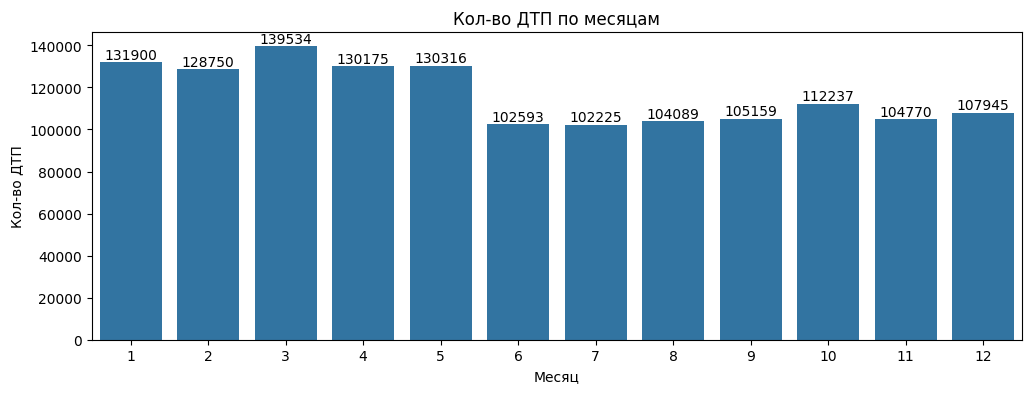

In [25]:
plt.figure(figsize=(12, 4))
barplot = sns.barplot(result, x='month', y='count');
plt.title('Кол-во ДТП по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Кол-во ДТП')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom')

plt.show()

Самым "аварийным" месяцем оказался март. Данный факт можно объяснить погодой, так как марте уже начинает теплеть, из-за чего часто на дорогах гололедица. Такими же погодными условиями можно, предположительно, объяснить большое количество аварий в январе и феврале. Однако на данный момент это лишь гипотезы, которые требуют дополнительного исследования.

### 3.2. <a id='toc3_2_'></a>Задачи для коллег [&#8593;](#toc0_)

Коллегам предлагается решить следующие задачи:

1) Проведите анализ серьезности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (`collisions` + `parties`)
2) Найдите самые частые причины ДТП (таблица `parties`)
3) Влияет ли алкоголь на количество аварий, то есть больше ли случаев ДТП с участием пьяных водителей по сравнению с трезвыми (таблица `parties`)
4) Является ли перекресток аварийно опасным участком (то есть там больше ДТП, чем не на перекрестках)? (таблица `collisions`)
5) Есть ли связь между серьезностью повреждений транспортного средства и трезвостью водителя? (`collisions` + `parties`)

### 3.3. <a id='toc3_3_'></a>Реализации задачи 1 [&#8593;](#toc0_)

План выполнения задачи:
1) Создать SQL запрос (не забыть объединить таблицы)
2) Построить график
3) Сделать вывод

In [90]:
query = '''
SELECT collision_damage,
       road_condition_1
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
'''

In [91]:
res = pd.read_sql(query, engine)
res.sample(5)

,collision_damage,road_condition_1
2162013,small damage,normal
2541381,small damage,normal
154243,middle damage,normal
2474590,scratch,normal
2043685,small damage,normal


In [92]:
get_value_counts(res['collision_damage'])

,count,part
collision_damage,,
small damage,1625999,0.590755
scratch,734188,0.266744
middle damage,315932,0.114784
severe damage,56335,0.020468
fatal,19954,0.007250


In [93]:
get_value_counts(res['road_condition_1'])

,count,part
road_condition_1,,
normal,2651223,0.971492
construction,39846,0.014601
holes,10274,0.003765
other,9914,0.003633
obstruction,9050,0.003316
loose material,4115,0.001508
reduced width,2884,0.001057
flooded,1717,0.000629


### 3.4. <a id='toc3_4_'></a>Реализация задачи 5 [&#8593;](#toc0_)

План выполнения задачи:
1) Создать SQL запрос (не забыть объединить таблицы)
2) Построить график
3) Сделать вывод

In [43]:
query = '''
SELECT CASE
           WHEN p.party_sobriety IN ('had been drinking, under influence', 'had been drinking, not under influence', 'had been drinking, impairment unknown') THEN 'drunk'
           WHEN p.party_sobriety = 'had not been drinking' THEN 'not drunk'
           ELSE NULL
        END AS drinking_category,
        c.collision_damage
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
WHERE p.party_sobriety IN ('had not been drinking', 'had been drinking, not under influence', 'had been drinking, under influence', 'had been drinking, impairment unknown')
'''

In [44]:
res = pd.read_sql(query, engine)
res.sample(5)

,drinking_category,collision_damage
527760,not drunk,fatal
84071,not drunk,small damage
526170,not drunk,scratch
936702,not drunk,scratch
13590,not drunk,small damage


In [78]:
res_dict = res.groupby(['drinking_category', 'collision_damage']).size().to_dict()
props = {}
for k in res_dict.keys():
    color = 'red' if k[0] == 'drunk' else 'green'
    props[k] = {'color': color}

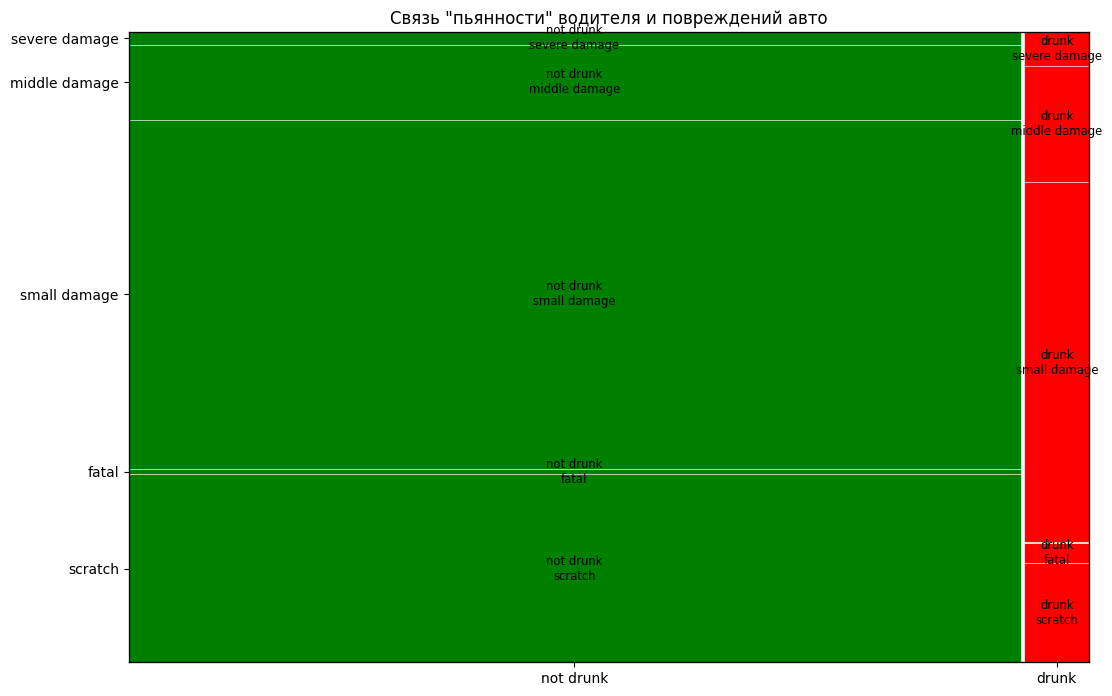

In [79]:
_, ax = plt.subplots(figsize=(12, 7))
mosaic(res, ['drinking_category', 'collision_damage'], ax=ax, title='Связь "пьянности" водителя и повреждений авто', properties=props)
plt.subplots_adjust(left=0.1, right=0.9, top=1, bottom=0.1)
plt.show()

In [65]:
absolute_counts = res.groupby(['drinking_category', 'collision_damage']).size().reset_index(name='count')
total_counts = res.groupby('drinking_category').size().reset_index(name='total_count')
merged_counts = pd.merge(absolute_counts, total_counts, on='drinking_category')
merged_counts['relative_count'] = merged_counts['count'] / merged_counts['total_count'] * 100

merged_counts \
    .pivot_table(values='relative_count', index='collision_damage', columns='drinking_category') \
    .reindex(['scratch', 'small damage', 'middle damage', 'severe damage', 'fatal']).agg(lambda x: round(x, 2))

drinking_category,drunk,not drunk
collision_damage,,
scratch,15.80,30.06
small damage,57.58,55.79
middle damage,18.40,11.71
severe damage,5.25,1.86
fatal,2.96,0.58


Анализ подтверждает идею - фактор "пьяный ли водитель за рулем" влияет на серьезность повреждений автомобиля. Например, повреждения среднего уровня и выше (`middle damage`, `severe damage` и `fatal`) получили автомобили в `26.6%` ДТП, если водитель был пьян, против `14.2%` при трезвом водителе.

## 4. <a id='toc4_'></a>Данные [&#8593;](#toc0_)

### 4.1. <a id='toc4_1_'></a>Загрузка данных [&#8593;](#toc0_)

In [29]:
query = '''
SELECT *
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
JOIN vehicles v ON c.case_id = v.case_id
WHERE c.collision_damage != 'scratch' AND
      DATE_PART('year', c.collision_date) = 2012 AND
      p.party_type = 'car'
'''

In [ ]:
df = pd.read_sql(query, engine)
df.head()

### 4.2. <a id='toc4_2_'></a>Отбор признаков [&#8593;](#toc0_)

In [ ]:
df.columns

In [ ]:
columns = [
    'county_city_location',
    'county_location',
    'distance',
    'direction',
    'intersection',
    'weather_1',
    'location_type',
    'collision_damage',
    'party_count',
    'primary_collision_factor',
    'pcf_violation_category',
    'type_of_collision',
    'motor_vehicle_involved_with',
    'road_surface',
    'road_condition_1',
    'lighting',
    'control_device',
    'collision_date',
    'collision_time',

    'id',
    'party_number',
    'party_type',
    'at_fault',
    'party_sobriety', # Уровень трезвости
    'party_drug_physical' # сонное состояние или нахождение под препоратами может влиять
    'cellphone_in_use',

    'party_number',
    'vehicle_transmission',
    'vehicle_age' # возраст автомобиля влияет на его состояние
]

In [ ]:
df = df[columns]

### 4.3. <a id='toc4_3_'></a>Проверка типов данных [&#8593;](#toc0_)

In [ ]:
df.info()

### 4.4. <a id='toc4_4_'></a>Оптимизация памяти [&#8593;](#toc0_)

In [ ]:
df = optimize_memory_usage(df)

### 4.5. <a id='toc4_5_'></a>Проверка полных дубликатов [&#8593;](#toc0_)

In [ ]:
check_duplicates(df)

### 4.6. <a id='toc4_6_'></a>Проверка пропусков [&#8593;](#toc0_)

In [ ]:
check_nans(df)

### 4.7. <a id='toc4_7_'></a>Корреляция [&#8593;](#toc0_)

### 4.8. <a id='toc4_8_'></a>Вывод [&#8593;](#toc0_)

## 5. <a id='toc5_'></a>Модели [&#8593;](#toc0_)

## 6. <a id='toc6_'></a>Проверка на тесте [&#8593;](#toc0_)

## 7. <a id='toc7_'></a>Вывод [&#8593;](#toc0_)